In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from DrlLibs.evaluate import evaluate_drl_agent
from DrlLibs.DRL_config import (
    get_algorithm_config, 
    get_training_config,
    print_algorithm_info
)
from DrlLibs import create_environment, load_and_evaluate
from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicyDemoAdaptiveAlpha, PolicySimulator, createEnv

In [2]:
configIdx = 0
(envParams, predictorParams) = (getEnvConfig(configIdx), getPredictorConfig(configIdx))
visualizeEnvConfig(envParams)
visualizePredictorConfig(predictorParams)
simEnv = createEnv(envParams, f'Results/TrafficData')
simEnv.selectMode(mode="test", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           4
Bandwidth:              40
M List:                 [2, 3]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernel_config{configIdx}.pkl', 'rb') as f:
    mdpPolicy = pickle.load(f)
adaptiveAlphaPolicy = PolicyDemoAdaptiveAlpha(envParams)

# ==== Prepare Simulator====
policySimulator = PolicySimulator(mdpPolicy, simEnv)
rewardRecord_mdp = policySimulator.runSimulation(mdpPolicy, num_epochs=5000, mode="test", type="data")
rewardRecord_adaptive = policySimulator.runSimulation(adaptiveAlphaPolicy, num_epochs=5000, mode="test", type="data")

# ==== Evaluate Policy====
_, eval_results = load_and_evaluate(envParams, simEnv, 
                  f'Results/DrlAgent/SAC_configure{configIdx}.zip', 
                  'SAC', 
                  num_episodes=10)
rewardRecord_drl = eval_results['episode_loss_rates']

Loading SAC model from Results/DrlAgent/SAC_configure0.zip

Evaluating SAC Agent
Evaluation Results:
  Average Reward: -11.7151 ± 0.6340
  Average Loss Rate: 0.0121 ± 0.0008
  Average Alpha: 0.7349
  Average Episode Length: 1000.00


Average Reward MDP:      0.0049
Average Reward Adaptive: 0.0409
Average Reward DRL:      0.0121


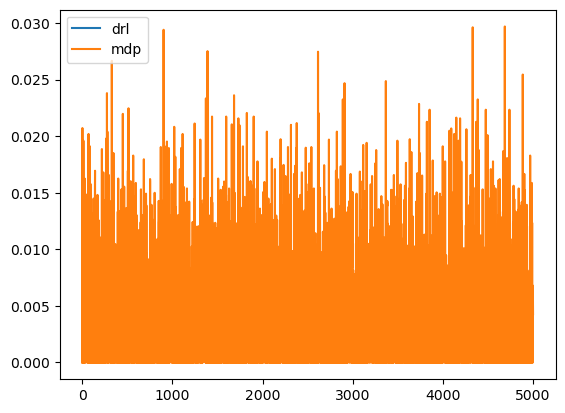

In [4]:
print(f"Average Reward MDP:      {np.mean(rewardRecord_mdp):.4f}")
print(f"Average Reward Adaptive: {np.mean(rewardRecord_adaptive):.4f}")
print(f"Average Reward DRL:      {np.mean(rewardRecord_drl):.4f}")

#plt.plot(rewardRecord_adaptive, label="adaptive")
plt.plot(rewardRecord_drl, label="drl")
plt.plot(rewardRecord_mdp, label="mdp")
plt.legend()
plt.show()